# HW 2: Generational Genetic algorithm


### Here is the reference to the dataset I am using [Alzheimer’s Prediction Dataset (Global)]: https://www.kaggle.com/datasets/ankushpanday1/alzheimers-prediction-dataset-global

## Data Preparation & NN Training

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Load the dataset
df = pd.read_csv("alzheimers_data.csv")

# Specify the 10 features and the target 
features = ['Age', 'Gender', 'Education Level', 'BMI', 'Physical Activity Level',
            'Smoking Status', 'Diabetes', 'Hypertension', 'Cholesterol Level', 'Family History of Alzheimer’s']
target = 'Alzheimer’s Diagnosis'

# Encode categorical features if needed
categorical_cols = ['Gender', 'Physical Activity Level', 'Smoking Status', 'Diabetes', 
                    'Hypertension', 'Cholesterol Level', 'Family History of Alzheimer’s']
for col in categorical_cols:
    if df[col].dtype == 'object':
        df[col] = LabelEncoder().fit_transform(df[col])

# Separate features and target
X = df[features].values
y = df[target].apply(lambda x: 1 if x=='Yes' else 0).values

# Standardize numeric features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train a simple 10-20-1 neural network using Keras
model = Sequential()
model.add(Dense(20, input_dim=10, activation='relu', name='hidden'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

print("Training baseline NN...")
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print("Baseline NN training accuracy:", train_acc)

# Extract the first layer weights
W_input_hidden, b_hidden = model.get_layer('hidden').get_weights()
W_vec = W_input_hidden.flatten()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training baseline NN...
Baseline NN training accuracy: 0.7145693898200989


## Genetic Algorithm Setup

In [ ]:
import numpy as np
import random

bit_length = len(W_vec)  # 200
num_masked = bit_length // 2  # 100 bits must be 0
pop_size = 2 * bit_length  # population size of 400
crossover_prob = 0.9
mutation_rate = 0.05  # increased mutation rate from 0.01 to 0.05
num_generations = 50

# Create an individual mask with exactly num_masked zeros
def create_individual():
    individual = np.ones(bit_length, dtype=int)
    zero_indices = np.random.choice(bit_length, num_masked, replace=False)
    individual[zero_indices] = 0
    return individual

# Repair an individual to ensure exactly num_masked zeros
def repair(ind):
    ones = np.sum(ind)
    target_ones = bit_length - num_masked
    if ones > target_ones:  # too many ones: flip some ones to zeros
        diff = ones - target_ones
        one_indices = np.where(ind == 1)[0]
        flip = np.random.choice(one_indices, diff, replace=False)
        ind[flip] = 0
        print(f"Repair: Flipped {diff} ones to zeros.")
    elif ones < target_ones:  # too few ones: flip some zeros to ones
        diff = target_ones - ones
        zero_indices = np.where(ind == 0)[0]
        flip = np.random.choice(zero_indices, diff, replace=False)
        ind[flip] = 1
        print(f"Repair: Flipped {diff} zeros to ones.")
    return ind

# Fitness function
def evaluate_fitness(mask, batch_size=256):
    # Sample a mini-batch from the training set 
    indices = np.random.choice(len(X_train), batch_size, replace=False)
    X_batch = X_train[indices]
    y_batch = y_train[indices]
    
    masked_W = (W_vec * mask).reshape(W_input_hidden.shape)
    orig_weights = model.get_layer('hidden').get_weights()[0].copy()
    model.get_layer('hidden').set_weights([masked_W, b_hidden])
    loss, acc = model.evaluate(X_batch, y_batch, verbose=0)

    model.get_layer('hidden').set_weights([orig_weights, b_hidden])
    return acc


# Crossover: Two-point or uniform 
def crossover(parent1, parent2):
    child1, child2 = parent1.copy(), parent2.copy()
    if random.random() < 0.5:
        # Two-point crossover
        points = sorted(random.sample(range(bit_length), 2))
        child1[points[0]:points[1]] = parent2[points[0]:points[1]]
        child2[points[0]:points[1]] = parent1[points[0]:points[1]]
        print(f"Crossover: Two-point between indices {points[0]} and {points[1]}.")
    else:
        # Uniform crossover
        for i in range(bit_length):
            if random.random() < 0.5:
                child1[i], child2[i] = parent2[i], parent1[i]
        print("Crossover: Uniform crossover executed.")
    return repair(child1), repair(child2)

# Mutation
def mutate(ind):
    for i in range(bit_length):
        if random.random() < mutation_rate:
            ind[i] = 1 - ind[i]
    print("Mutation: Mutation applied.")
    return repair(ind)

# Selection Methods
def fitness_proportionate(population, fitnesses):
    total_fit = sum(fitnesses)
    pick = random.uniform(0, total_fit)
    current = 0
    for ind, fit in zip(population, fitnesses):
        current += fit
        if current > pick:
            return ind
    return population[-1]

def tournament_selection(population, fitnesses, tournament_size=10):
    selected = random.sample(list(zip(population, fitnesses)), tournament_size)
    selected.sort(key=lambda x: x[1], reverse=True)
    return selected[0][0]

# Compute average Hamming distance for a sample of individuals to assess diversity
def compute_diversity(population, sample_size=10):
    sample = random.sample(population, sample_size)
    distances = []
    for i in range(len(sample)):
        for j in range(i+1, len(sample)):
            distances.append(np.sum(sample[i] != sample[j]))
    avg_distance = np.mean(distances) if distances else 0
    return avg_distance

# Initialize population
population = [create_individual() for _ in range(pop_size)]
print("Initial population created.")

Initial population created.


## Run the GA

In [24]:
def run_ga(selection_method):
    best_individual = None
    best_fitness = -np.inf
    current_pop = population.copy()
    history = []
    stagnation_counter = 0

    for gen in range(num_generations):
        print("\n----------------------------------")
        print(f"Generation {gen+1} starting...")
        # Evaluate fitness for each individual with detailed prints
        fitnesses = []
        for idx, ind in enumerate(current_pop):
            fit = evaluate_fitness(ind)
            fitnesses.append(fit)
            if idx < 3:  # Print fitness for first few individuals for debug
                print(f"Individual {idx} fitness: {fit:.4f}")

        gen_best_index = np.argmax(fitnesses)
        gen_best = current_pop[gen_best_index].copy()
        current_best_fitness = fitnesses[gen_best_index]
        print(f"Generation {gen+1}: Best Fitness = {current_best_fitness:.4f}")

        avg_fitness = np.mean(fitnesses)
        std_fitness = np.std(fitnesses)
        print(f"Generation {gen+1}: Average Fitness = {avg_fitness:.4f}, Std Dev = {std_fitness:.4f}")
        
        diversity = compute_diversity(current_pop)
        print(f"Generation {gen+1}: Population Diversity (avg Hamming distance) = {diversity:.2f}")

        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_individual = gen_best.copy()
            stagnation_counter = 0
            print(f"New overall best found: {best_fitness:.4f}")
        else:
            stagnation_counter += 1
            print(f"No improvement in this generation. Stagnation counter: {stagnation_counter}")

        # Stagnation handling: reinitialize 10% of population if stagnation for 5 generations
        if stagnation_counter >= 5:
            num_reinit = int(0.1 * pop_size)
            print(f"Stagnation detected. Reinitializing {num_reinit} individuals to boost diversity.")
            for _ in range(num_reinit):
                idx = random.randint(0, pop_size-1)
                current_pop[idx] = create_individual()
            stagnation_counter = 0

        new_pop = [gen_best]  

        # Create new individuals until population is replenished
        while len(new_pop) < pop_size:
            # Parent selection using the given method
            if selection_method == 'fitness':
                parent1 = fitness_proportionate(current_pop, fitnesses)
                parent2 = fitness_proportionate(current_pop, fitnesses)
                print("Selected two parents using fitness proportionate selection.")
            elif selection_method == 'tournament':
                parent1 = tournament_selection(current_pop, fitnesses, tournament_size=10)
                parent2 = tournament_selection(current_pop, fitnesses, tournament_size=10)
                print("Selected two parents using tournament selection.")
            else:
                raise ValueError("Unknown selection method")

            # Crossover
            if random.random() < crossover_prob:
                child1, child2 = crossover(parent1, parent2)
                print("Crossover performed.")
            else:
                child1, child2 = parent1.copy(), parent2.copy()
                print("No crossover; children copied directly from parents.")

            # Mutation
            child1 = mutate(child1)
            child2 = mutate(child2)
            print("Children mutated.")

            new_pop.extend([child1, child2])
        
        current_pop = new_pop[:pop_size]
        history.append(best_fitness)
        print(f"Generation {gen+1} complete. Best Fitness so far: {best_fitness:.4f}")

    return best_individual, best_fitness, history

# RUN GA

print("\n=== Running GA with Fitness Proportionate Selection ===")
best_mask_fp, best_fitness_fp, history_fp = run_ga('fitness')

print("\n=== Running GA with Tournament Selection ===")
best_mask_tourn, best_fitness_tourn, history_tourn = run_ga('tournament')


=== Running GA with Fitness Proportionate Selection ===

----------------------------------
Generation 1 starting...
Individual 0 fitness: 0.5820
Individual 1 fitness: 0.5586
Individual 2 fitness: 0.6992
Generation 1: Best Fitness = 0.8008
Generation 1: Average Fitness = 0.6393, Std Dev = 0.0917
Generation 1: Population Diversity (avg Hamming distance) = 99.24
New overall best found: 0.8008
Selected two parents using fitness proportionate selection.
Crossover: Uniform crossover executed.
Repair: Flipped 2 zeros to ones.
Repair: Flipped 2 ones to zeros.
Crossover performed.
Mutation: Mutation applied.
Repair: Flipped 2 zeros to ones.
Mutation: Mutation applied.
Repair: Flipped 2 ones to zeros.
Children mutated.
Selected two parents using fitness proportionate selection.
Crossover: Uniform crossover executed.
Repair: Flipped 3 ones to zeros.
Repair: Flipped 3 zeros to ones.
Crossover performed.
Mutation: Mutation applied.
Repair: Flipped 7 zeros to ones.
Mutation: Mutation applied.
Chil

## Confusion Matrices the Best GA Individual & Baseline


=== Evaluating Best GA Individual on Training and Test Sets ===
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
Confusion Matrix on Training Data:
[[25827  9024]
 [ 7912 16663]]


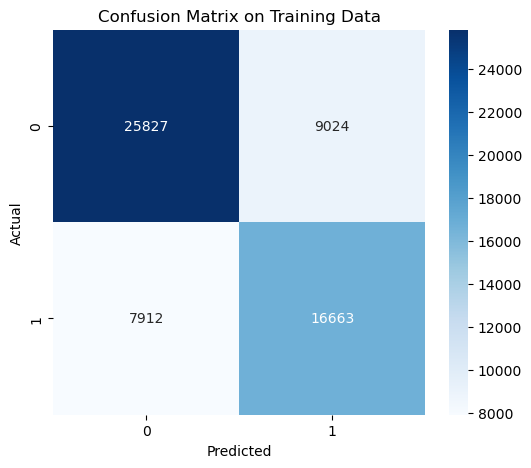

465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
Confusion Matrix on Test Data:
[[6468 2251]
 [1975 4163]]


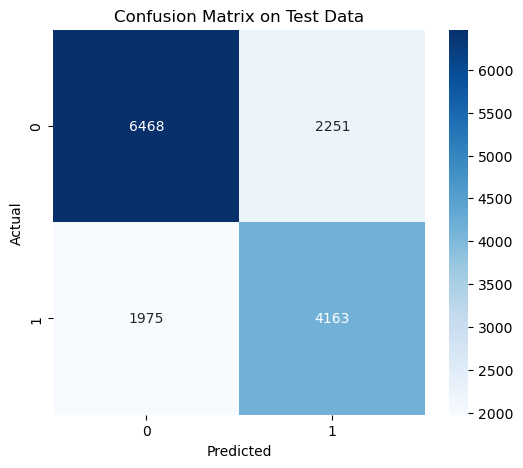


=== Evaluating Baseline (Highest-Magnitude Weights) ===
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
Confusion Matrix on Training Data (Baseline):
[[25829  9022]
 [ 7933 16642]]


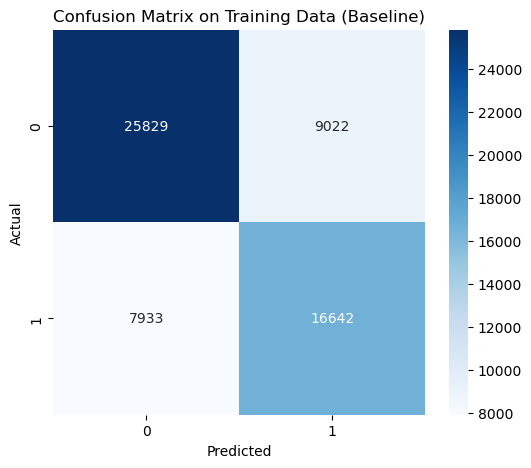

465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
Confusion Matrix on Test Data (Baseline):
[[6487 2232]
 [1997 4141]]


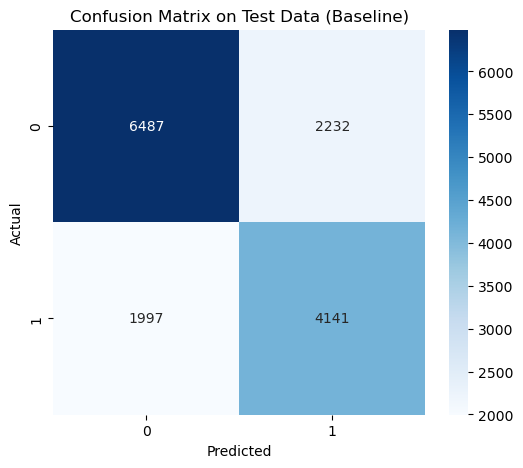

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, dataset_name="Data"):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix on {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def evaluate_mask_on_data(mask, X, y, dataset_name="Data"):
    masked_W = (W_vec * mask).reshape(W_input_hidden.shape)
    orig_weights = model.get_layer('hidden').get_weights()[0].copy()
    model.get_layer('hidden').set_weights([masked_W, b_hidden])

    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
    cm = confusion_matrix(y, y_pred)
    print(f"Confusion Matrix on {dataset_name}:\n{cm}")
    plot_confusion_matrix(cm, dataset_name=dataset_name)
   
    model.get_layer('hidden').set_weights([orig_weights, b_hidden])
    return cm

print("\n=== Evaluating Best GA Individual on Training and Test Sets ===")
cm_train = evaluate_mask_on_data(best_mask_tourn, X_train, y_train, dataset_name="Training Data")
cm_test  = evaluate_mask_on_data(best_mask_tourn, X_test, y_test, dataset_name="Test Data")

print("\n=== Evaluating Baseline (Highest-Magnitude Weights) ===")
cm_train_baseline = evaluate_mask_on_data(baseline_mask, X_train, y_train, dataset_name="Training Data (Baseline)")
cm_test_baseline  = evaluate_mask_on_data(baseline_mask, X_test, y_test, dataset_name="Test Data (Baseline)")


## Summary

### In our test, applying a genetic algorithm to apply a 50% weight mask to a 10‑20‑1 neural network revealed that parameter tuning of, for example, mutation rate and the addition of stagnation handling can be utilized to obtain significantly higher performance than a baseline of merely retaining the highest-magnitude weights. Most notable, tournament selection outperformed fitness proportionate selection by providing marginally better fitness and more balanced classification performance, as shown by the confusion matrices. In total, the GA was capable of discovering a sparse configuration that maintained or enhanced predictive accuracy, showing the potential for evolutionary methods to the optimization of neural network connectivity.